In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
from PIL import Image
import matplotlib.patches as mpatches
import colorsys
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from sklearn.cluster import MeanShift, estimate_bandwidth

# tgtroot = '/media/senseable-beast/beast-brain-1/Data/streetviewdata/img/'
tgtroot = 'C:/Users/lezhi/Dropbox/thesis/img/'
dataroot = 'C:/Users/lezhi/Dropbox/thesis/data/'

In [2]:
cat_labels = ["Sky", "Building", "Pole", "Unlabelled", "Road", \
        "Pavement", "Tree", "SignSymbol", "Fence", \
        "Car", "Pedestrian", "Bicyclist"]

# def getmask(a, **kwargs):
#     inds = [labels.index(c)+243 for c in kwargs['category']]    
#     return [(ele in inds) for ele in np.nditer(a)]

# much better performance than the commented method...:
'''input a 2D index matrix, return a 2D boolean matrix 
where True means the pixel belongs to one of the specified "category".'''

def getmask(a, **kwargs):    
    inds = [cat_labels.index(c)+243 for c in kwargs['category']] 
    # print np.array(inds)-243
    indicators = np.zeros((a.shape[0], a.shape[1], len(inds))).astype(np.uint8)
    for i in range(len(inds)):
        indicators[:,:,i] = np.array(np.squeeze([a==inds[i]]))
    return np.any(indicators, axis=2)


# distinct and major color in ALL images (in 4-groups)

In [6]:
df = pd.DataFrame()

def iter_dir_4(rootdir, dostuff):
    
    citynames = np.array(sorted([d for d in os.listdir(rootdir) if os.path.isdir(rootdir)]))
    for cityname in citynames[np.array([1,3,7,9])]:   ######################
        print cityname
        citypath = rootdir + cityname
        imgnames = sorted([f[:-4] for f in os.listdir(citypath) if os.path.isfile(os.path.join(citypath, f))])
        
        lat_lng_dir = np.array([name.replace('_',',').split(',')[:2] for name in imgnames])
        df1 = pd.DataFrame(lat_lng_dir, columns=['lat', 'lng']).astype(str)############################################
        #df1['city'] = cityname
        df1['imgnames'] = [cityname + "/" + i+".png" for i in imgnames]
        df1gb = df1.groupby(['lat','lng'])
        
        df = df1gb.agg({"imgnames": lambda x: tuple(x)}).reset_index()
    
        records = df['imgnames'].apply(dostuff)
        del df['imgnames']
#         print records.values        
        
        df2 = pd.DataFrame.from_records(list(records.values), columns = ['H', 'S', 'V', 'color'])
#         print df2
    
        df = pd.concat([df, df2], axis=1)
        df.to_csv(dataroot + 'color4_' + cityname +'.csv')
        

In [7]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

# each row is a tuple of image names
def cal_color_4(row):
    imarr = np.zeros([360, 480*len(row), 4]).astype(np.uint8) 
    for i in range(len(row)):
        indi_imarr = np.array(Image.open(tgtroot+ row[i])) # 51.45386,-0.138461068985_
        imarr[:, i*480 : (i+1)*480, :] = indi_imarr

    alpha = imarr[:, :, 3]
    
    mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"]) ##
    if np.sum(mask) < 70000: ###################
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        base = (0*np.ones((360, 480*len(row), 3))).astype(np.uint8)
        base[mask] = (imarr[:,:,:3])[mask]
        color_array = (imarr[:,:,:3])[mask]
        
        def not_black(hsv):         
            return hsv[2] > 0.001
        majority_func = lambda s: s[2]
        ms_quantile = 0.12

        image = (base.astype(np.float64)) /255

        w, h, d = original_shape = tuple(image.shape)
        assert d == 3
        image_array = np.reshape(image, (w * h, d))
        image_array_sample = shuffle(image_array, random_state=0)[:1000]

        bandwidth = estimate_bandwidth(image_array_sample, quantile=ms_quantile)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
        labels = ms.predict(image_array)
        labels_unique = np.unique(labels)
        n_clusters = len(labels_unique)
        centers = ms.cluster_centers_

        centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

        # tuples of index, color, number of pixels with that color
        sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
        non_black = [i for i in sum_info if not_black(i[1])]
        fq_c = max(non_black , key=majority_func)  

        def rgb_to_hex(rgb):
            rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
            return '#%02x%02x%02x' % rgb_

        out_rgb = fq_c[1]
        out_hex = rgb_to_hex(colorsys.hsv_to_rgb(out_rgb[0], out_rgb[1], out_rgb[2]))

        return (out_rgb[0], out_rgb[1], out_rgb[2], out_hex)

In [ ]:

iter_dir_4(tgtroot, cal_color_4)

# color clustering for the whole city

In [29]:
import struct
rgbstr='605540'
struct.unpack('BBB',rgbstr.decode('hex'))

(96, 85, 64)

In [24]:
color_df = pd.read_csv(dataroot+'color4_boston.csv', index_col=0)

In [36]:
color_df.head(20)

,lat,lng,_r,_g,_b,color
0,42.298631,-71.083094,0.106372,0.328955,0.378959,#605540
1,42.298631,-71.085124,0.338415,0.051866,0.344444,#535753
2,42.298631,-71.087153,NaN,NaN,NaN,NaN
3,42.298631,-71.089183,NaN,NaN,NaN,NaN
4,42.298631,-71.099332,NaN,NaN,NaN,NaN
5,42.300131,-71.072945,0.192214,0.072029,0.257201,#40413c
6,42.300131,-71.074975,0.542276,0.137676,0.389281,#555f63
7,42.300131,-71.077005,0.093395,0.205779,0.500744,#7f7465
8,42.300131,-71.079034,0.086941,0.309211,0.325145,#524639
9,42.300131,-71.081064,0.154250,0.089763,0.324406,#52524b


In [50]:
ms_quantile = 0.12

w, h, d = original_shape = tuple(image.shape)
assert d == 3
color_array = np.array([np.array(struct.unpack('BBB',rgbstr[1:].decode('hex'))) for rgbstr in color_df['color'].dropna().values])

bandwidth = estimate_bandwidth(color_array, quantile=ms_quantile)
#ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(color_array)
ms = KMeans().fit(color_array)

labels = ms.predict(color_array)
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
centers = ms.cluster_centers_

def rgb_to_hex(rgb):
            rgb_ = tuple(((np.array(rgb)).astype(np.uint8))) 
            return '#%02x%02x%02x' % rgb_

centers_hex = [rgb_to_hex(i) for i in centers]
#centers_hex = [rgb_to_hex(colorsys.hsv_to_rgb(i[0],i[1],i[2])) for i in centers]
print centers_hex
 

['#5a574d', '#c6c4b9', '#3e373b', '#a3989a', '#e4dfe4', '#000000', '#000000', '#7e1d1f']


In [41]:
rgb_to_hex([ 176.12280702,  171.80701754,  164.14619883])

'#6f2281'

In [45]:
color_array[labels==5]

array([[ 96,  47,  35],
       [139,  74,  59],
       [126,  29,  31]])

In [39]:
labels[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 3, 1, 0, 3], dtype=int64)

# major color from one point (4 images)

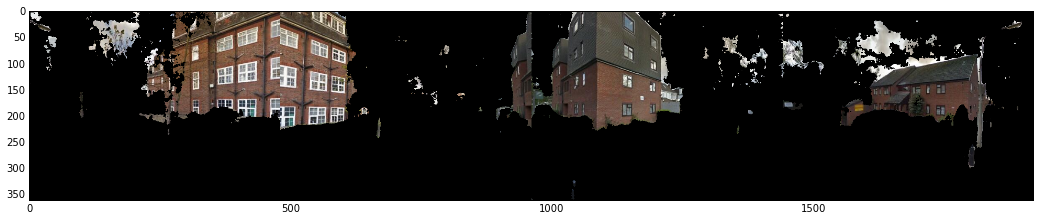

In [4]:
imarr = np.zeros([360,4*480,4]).astype(np.uint8) 
for i in range(4):
    indi_imarr = np.array(Image.open(tgtroot+'london/51.46136,-0.0926716179225_'+str(i)+'.png')) # 51.45386,-0.138461068985_
    imarr[:,i*480:(i+1)*480,:] = indi_imarr

alpha = imarr[:, :, 3]

mask = getmask(imarr[:,:,3], category=["Building", "SignSymbol", "Pole"])
base = (0*np.ones((360,480*4,3))).astype(np.uint8)
base[mask] = (imarr[:,:,:3])[mask]
color_array = (imarr[:,:,:3])[mask]
    
plt.figure(figsize=(18, 6))
plt.imshow(base) # plt.imshow(imarr)

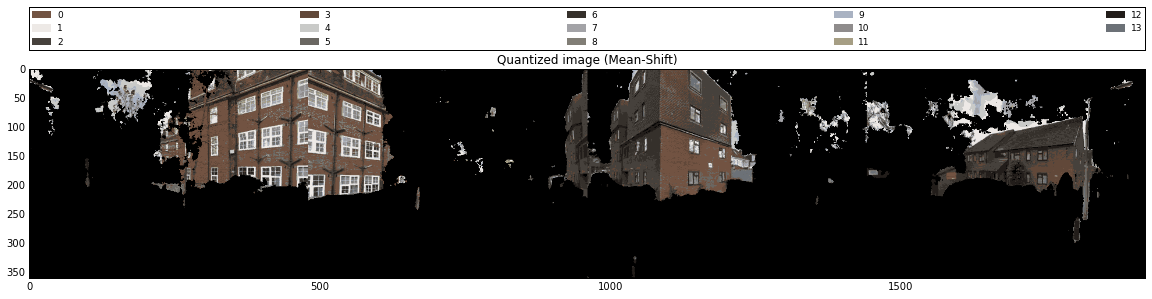

In [5]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

def not_black(hsv):
    return hsv[2] > 0.001

majority_func = lambda s: s[2]*s[1][2]

ms_quantile = 0.12

image = Image.fromarray(base, 'RGB')
image = np.array(image, dtype=np.float64) / 255

# transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]

bandwidth = estimate_bandwidth(image_array_sample, quantile=ms_quantile)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(image_array_sample)
labels = ms.predict(image_array)

#print "ms.cluster_centers_:", ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters = len(labels_unique)
#print 'n_clusters:', n_clusters
centers = ms.cluster_centers_

centers_hsv = [colorsys.rgb_to_hsv(i[0],i[1],i[2]) for i in centers]

# tuples of index, color, number of pixels with that color
sum_info = [(i, centers_hsv[i], np.sum(labels == i)) for i in range(len(centers_hsv))]
#print 'sum_info', sum_info
non_black = [i for i in sum_info if not_black(i[1])]
fq_c = sorted(non_black , key=majority_func, reverse=True)
#print "most frequent color:", fq_c

X_s = [i[1] for i in fq_c]

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image
#print "labels:", np.unique(labels)

# Display all results, alongside original image
plt.figure(figsize=(20, 15))

# plt.subplot(122)
plt.title('Quantized image (Mean-Shift)')
# new_cookbook = np.array([cluster_centers[i] for i in ms_labels])
new_cookbook = centers
plt.imshow(recreate_image(new_cookbook, labels, w, h))

lg_handles = []
lg_labels = []
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
def rgb_to_hex(rgb):
    rgb_ = tuple(((np.array(rgb)*255).astype(np.uint8))) 
    # print '#%02x%02x%02x' % rgb_
    return '#%02x%02x%02x' % rgb_

for i in range(len(X_s)):
    hexi = rgb_to_hex(tuple(colorsys.hsv_to_rgb(X_s[i][0], X_s[i][1], X_s[i][2])))
    rect = mpatches.Patch(color=hexi)
    lg_handles.append(rect)
    lg_labels.append(str(i))
plt.legend(lg_handles,lg_labels,bbox_to_anchor=(0. ,1.09 ,1.,0.3),loc=8,
           ncol=5,mode='expand',borderaxespad=0,prop={'size':9},numpoints=1)